# Postprocessing Demo
This notebook explains step by step how raw depth maps are refined and cleaned up.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import csv
import scipy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from mit_semseg.utils import colorEncode
from megadepth.postprocessing.cleanup import refine_depth_maps
from megadepth.postprocessing.image_processing import erode_and_remove, filter_unstable_depths, median_filter
from megadepth.postprocessing.semantic_filtering import (
    get_mask,
    apply_semantic_filtering,
    get_ordinal_labels,
    is_selfie_image,
)
from megadepth.postprocessing.semantic_segmentation import (
    get_segmentation_map,
    get_segmentation_model,
)
from megadepth.utils.io import load_depth_map

In [3]:
def plot_images(images: list, titles: list) -> None:
    fig = plt.figure(figsize=(10, 10))

    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1)
        plt.axis("off")
        plt.imshow(images[i])
        plt.title(titles[i])
 
    plt.show()


# ADE20K dataset information
colors = scipy.io.loadmat("color150.mat")["colors"]
names = {}
with open("object150_info.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

Feel free to change the variables in the following cell to try out other images and depth maps:

In [4]:
def show_image_depth_filtered(image_name, dense_model_dir):
    try:
        image = Image.open(os.path.join(dense_model_dir, "..","..","images", image_name)).convert("RGB")
        depth_map = load_depth_map(os.path.join(dense_model_dir, "stereo", "depth_maps", f"{image_name}.geometric.bin"))
        filtered_depth_map = depth_map
        plot_images([image, np.log(depth_map), np.log(filtered_depth_map)], ["Image", "Raw Depth Map","Filtered Depth Map"])
    except :
        print("skipped", image_name)

skipped 30193952763_b09f4b97cd_o.jpg


/tmp/ipykernel_19066/1439681237.py:6: RuntimeWarning: divide by zero encountered in log
  plot_images([image, np.log(depth_map), np.log(filtered_depth_map)], ["Image", "Raw Depth Map","Filtered Depth Map"])


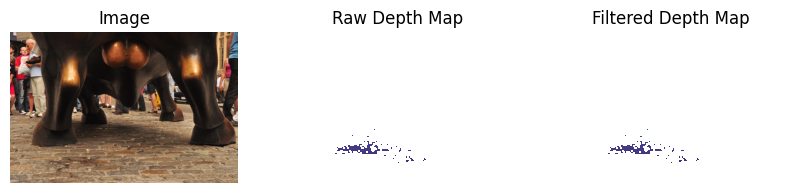

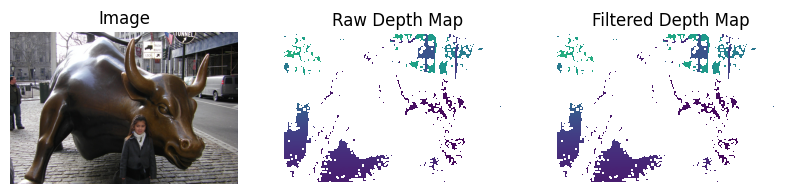

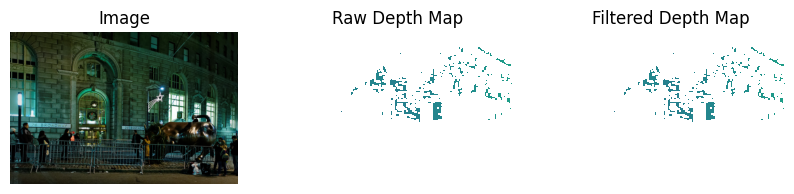

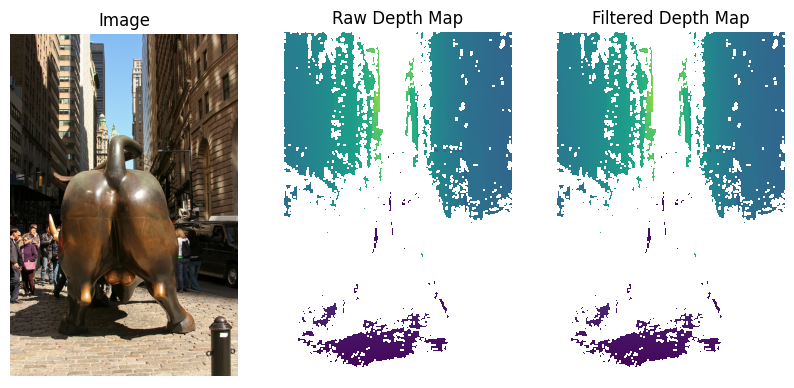

In [5]:
model_dir = os.path.join("..", "data", "0229")
dense_model_dir = os.path.join("..", "data", "0229", "dense", "superpoint_max-superglue-netvlad-50-KA+BA")
image_names = os.listdir(os.path.join(model_dir,"images"))
for image_name in image_names[:5]:
    show_image_depth_filtered(image_name,dense_model_dir)


In [ ]:
dense_model_dir = os.path.join("..", "data", "0229", "dense", "superpoint_max-superglue-netvlad-50-KA+BA")
image_fn = "51039207_eb853788fd_o.jpg"

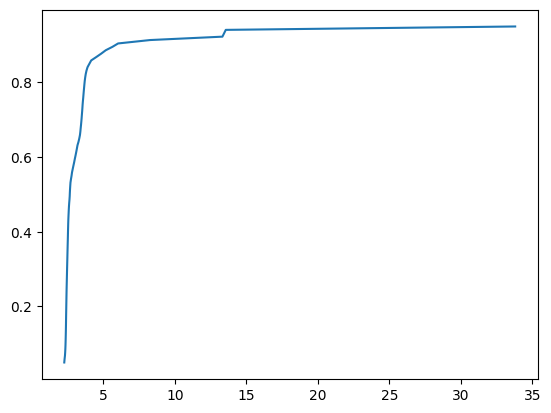

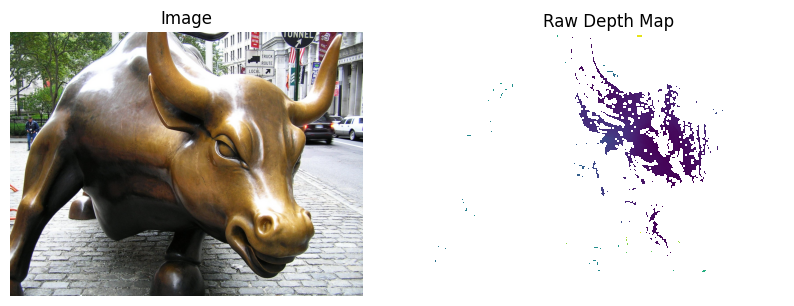

In [10]:
image = Image.open(os.path.join(dense_model_dir, "..","..","images", image_fn)).convert("RGB")
depth_map = load_depth_map(os.path.join(dense_model_dir, "stereo", "depth_maps", f"{image_fn}.geometric.bin"))

d = depth_map[depth_map!=0]
q = np.linspace(0.05,0.95,100)
cum = np.quantile(d,q)

plt.plot(cum,q)
plt.show()
filtered_depth_map = median_filter(depth_map, 3)
min = np.quantile(d, 0.1)
max = np.quantile(d, 0.9)
depth_map[depth_map>max] = np.nan
depth_map[depth_map<min] = np.nan


plot_images([image, np.log(depth_map)], ["Image", "Raw Depth Map"])

### Semantic Segmentation
As a first step, we extract a segmentation map from the image.

In [21]:
model = get_segmentation_model()
#segmentation_map = get_segmentation_map(image, model)

#plot_images([image, colorEncode(segmentation_map, colors)], ["Image", "Segmentation Map"])

Loading weights for net_encoder
Loading weights for net_decoder


The quality of the segmentation seems to suffer when you reduce the image size.

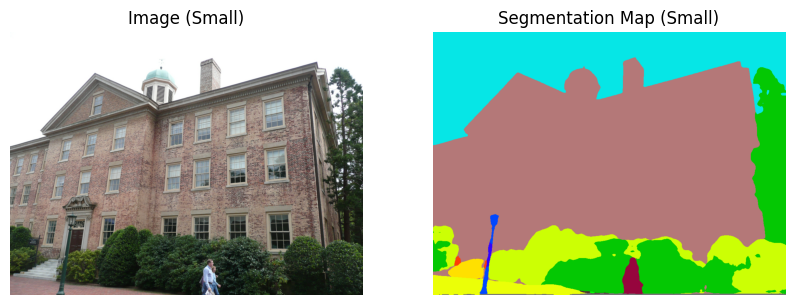

In [22]:
# downscale image to such that the largest dimension is 512 pixels.
size = 1024
scale = size / max(image.size)
new_size = tuple(int(x * scale) for x in image.size)
image_small = image.resize(new_size)

segmentation_map_small = get_segmentation_map(image_small, model)
h, w = depth_map.shape
segmentation_map = cv2.resize(segmentation_map_small.astype(np.uint8), dsize=(w,h),interpolation=cv2.INTER_NEAREST)
plot_images([image_small, colorEncode(segmentation_map_small, colors)], ["Image (Small)", "Segmentation Map (Small)"])

### Semantic Filtering

Using the segmentation map, we can extract the following masks:

- **Foreground mask**
    - Labels: person, table, chair, seat, signboard, flower, book, bench, boat, bus, truck, 
    streetlight, booth, poster, van, ship, fountain, bag, minibike, ball, animal, bicycle, 
    sculpture, traffic light, bulletin board
    - Label IDs: 12, 15, 19, 31, 43, 66, 67, 69, 76, 80, 83, 87, 88, 100, 102, 103, 104, 115, 116, 119, 126, 127, 132, 136, 144

- **Background mask**
    - Labels: building, house, skyscraper, hill, tower, waterfall, mountain
    - Label IDs: 1, 25, 48, 68, 84, 113, 16

- **Sky mask**
    - Labels: sky
    - Label IDs: 2

*Note: The label IDs above are 0-indexed (just like in the segmentation maps) while the label IDs in the ADE20K CSV file are 1-indexed.*

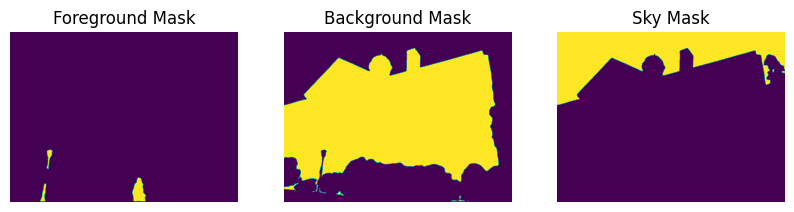

In [23]:
foreground_mask = get_mask(segmentation_map, "foreground")
background_mask = get_mask(segmentation_map, "background")
sky_mask = get_mask(segmentation_map, "sky")

plot_images([foreground_mask, background_mask, sky_mask], ["Foreground Mask", "Background Mask", "Sky Mask"])

### Image Processing

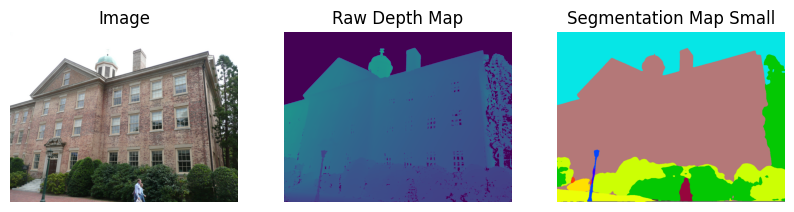

In [24]:
plot_images([image, depth_map, colorEncode(segmentation_map_small, colors)], ["Image", "Raw Depth Map", "Segmentation Map Small"])

Apparently colmap already implements some sort of median filtering. Since median filtering doesnt do anything with the suggested parameters

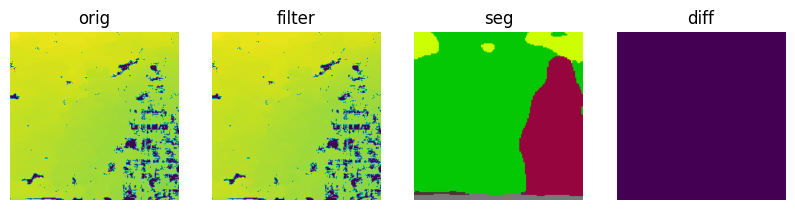

In [41]:
crop = depth_map[-300:,-1300:-1000]
crop_seg = segmentation_map[-300:,-1300:-1000]
crop_filt = filter_unstable_depths(crop,kernel_size=7,threshold=1.05)
plot_images([crop,crop_filt, colorEncode(crop_seg,colors),crop-crop_filt], ["orig", "filtered", "seg","diff"])

0.9974344878138172
0.8205149570869095
0.9714755896873286


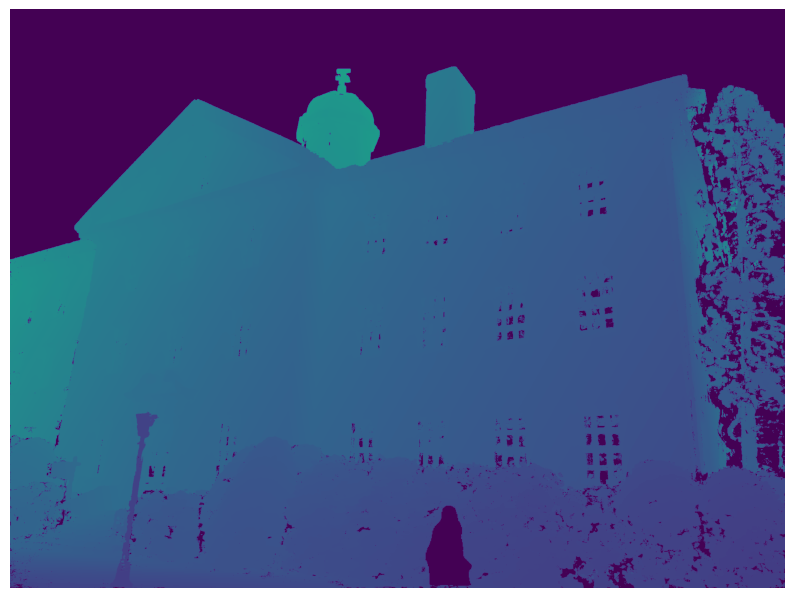

In [52]:
from megadepth.postprocessing.semantic_filtering import check_semantics
d = check_semantics(foreground_mask, depth_map,0.9)
plot_images([d],[""])
#depth_map = apply_semantic_filtering(depth_map, segmentation_map)
#depth_map = erode_and_remove(depth_map)